### 1) EXACT APPROACH: BRANCH-AND-BOUND $^{3}$
##### a) Initiate library and variables

In [110]:
import pandas as pd
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
from ortools.algorithms import pywrapknapsack_solver

In [111]:
# taken from OR-tools docs https://developers.google.com/optimization/bin/knapsack

values = [
    360, 83, 59, 130, 431, 67, 230, 52, 93, 125, 670, 892, 600, 38, 48, 147,
    78, 256, 63, 17, 120, 164, 432, 35, 92, 110, 22, 42, 50, 323, 514, 28,
    87, 73, 78, 15, 26, 78, 210, 36, 85, 189, 274, 43, 33, 10, 19, 389, 276,
    312
]
weights = [[
    7, 0, 30, 22, 80, 94, 11, 81, 70, 64, 59, 18, 0, 36, 3, 8, 15, 42, 9, 0,
    42, 47, 52, 32, 26, 48, 55, 6, 29, 84, 2, 4, 18, 56, 7, 29, 93, 44, 71,
    3, 86, 66, 31, 65, 0, 79, 20, 65, 52, 13
]]
capacities = [850]

##### b) Define solver function for exact method

In [112]:
def knapsack_solver(values, weights, capacities, is_detail=False):
    
    # defining solver from ortools
    solver = pywrapknapsack_solver.KnapsackSolver(
        pywrapknapsack_solver.KnapsackSolver.
        KNAPSACK_MULTIDIMENSION_BRANCH_AND_BOUND_SOLVER, 'KnapsackExample')

    solver.Init(values, weights, capacities)
    total_value = solver.Solve()
    
    # to capture total of weight inside the knapsack
    total_weight = 0
    
    # for detailed input, add information of weight packed inside the knapsack
    if is_detail == True:
        total_packed_weight = []
        for i in range(len(values)):
            if solver.BestSolutionContains(i):
                total_packed_weight.append(weights[0][i])
                total_weight += weights[0][i]
            else:
                total_packed_weight.append(-1)
    
    # for non-detailed input, skip the step of adding information of weight packed inside the knapsack
    else:
        total_packed_weight = None
        for i in range(len(values)):
            if solver.BestSolutionContains(i):
                total_weight += weights[0][i]

    return total_value, total_weight, total_packed_weight

##### c) Get result

In [113]:
total_value_simple, total_weight_simple, total_packed_weight_simple = knapsack_solver(values, weights, capacities, True)

print('total_value:', total_value_simple)
print('total_weight:', total_weight_simple)
print('total_packed_weight:', total_packed_weight_simple)

total_value: 7534
total_weight: 850
total_packed_weight: [7, 0, -1, 22, 80, -1, 11, -1, -1, -1, 59, 18, 0, -1, 3, 8, 15, 42, 9, 0, -1, 47, 52, -1, 26, -1, -1, 6, 29, 84, 2, 4, 18, -1, 7, -1, -1, -1, 71, 3, -1, 66, 31, -1, 0, -1, -1, 65, 52, 13]


### 2) WHEN UNCERTAINTY APPEARS: COMPARE SOLUTIONS
##### a) Initiate variables to add randomness (will also be used in section (3) below)

In [114]:
delta = 0.2 * np.array(weights[0])
num_samp = 1000
N = 50

# random samples for z
rd.seed(42)
zs = 1-2*rd.rand(num_samp, N) 

##### b) Initiate simulation function where the input has a particular degree of uncertainty (will also be used in section (3) below)

In [115]:
def simulate_result(solver_func, capacities, values, weights, delta, zs, num_samp, total_packed_weight_init, uncertainty_budget=0.0, is_detail=True):
    
    # initiate number of item
    N = len(values)
    
    # initiate empty list to cater result later
    list_weights = []

    list_total_values = []
    list_total_weights = []
    list_mean_deviation_weights = []

    list_total_values_prev = []
    list_total_weights_prev = []
    
    for idx in range(num_samp):
        
        # initiate weights with deviation, using zs and delta as parameter
        temp_weights = [list((weights + zs[idx] * delta).astype('int'))]
        
        # get the absolute deviation
        temp_mean_deviation_weights = abs(temp_weights - weights)
    
        # run solver
        if solver_func == knapsack_solver:
            total_value, total_weight, total_packed_weight = solver_func(
                values, temp_weights, capacities, is_detail
            )
        elif solver_func == rsome_solver:
            total_value, total_weight, total_packed_weight = solver_func(
                values, np.array(temp_weights[0]), capacities, uncertainty_budget, is_detail
            )

        # new solution - solution after the initial input has a particular degree of uncertainty
        list_weights.append(sum(temp_weights[0]))
        list_total_values.append(total_value)
        list_total_weights.append(total_weight)
        list_mean_deviation_weights.append((temp_mean_deviation_weights * np.where(np.array(total_packed_weight) > -1, 1, 0)).sum() / N)

        # previous solution - check values and weight if the previous solution is still implemented
        list_total_values_prev.append((values * np.where(np.array(total_packed_weight_init) > -1, 1, 0)).sum())
        list_total_weights_prev.append((np.array(temp_weights[0]) * np.where(np.array(total_packed_weight_init) > -1, 1, 0)).sum())
        
    result_dict = {
        'weights': list_weights,
        'total_values': list_total_values,
        'total_weights': list_total_weights,
        'mean_deviation_weights': list_mean_deviation_weights,
        'total_values_prev': list_total_values_prev,
        'total_weights_prev': list_total_weights_prev   
    }
    
    return result_dict

##### c) Collect simulation result to a dataframe

In [116]:
# run simulation
result_sim_simple = simulate_result(knapsack_solver, capacities, values, np.array(weights[0]), delta, zs, num_samp, total_packed_weight_simple)

# convert dictionary to dataframe
df_sim_simple = pd.DataFrame(result_sim_simple)
df_sim_simple['is_greater_than_values_prev'] = np.where(df_sim_simple['total_values'] > df_sim_simple['total_values_prev'], 1, 0)
df_sim_simple['is_greater_than_capacities'] = np.where(df_sim_simple['total_weights_prev'] > capacities[0], 1, 0)
df_sim_simple

,weights,total_values,total_weights,mean_deviation_weights,total_values_prev,total_weights_prev,is_greater_than_values_prev,is_greater_than_capacities
0,1900,7440,849,1.46,7534,889,0,1
1,1873,7543,850,1.94,7534,856,1,1
2,1889,7534,850,1.58,7534,857,0,1
3,1823,7654,846,2.16,7534,807,1,0
4,1820,7714,846,1.94,7534,779,1,0
...,...,...,...,...,...,...,...,...
995,1780,7663,847,2.16,7534,811,1,0
996,1822,7672,850,2.06,7534,794,1,0
997,1897,7484,841,1.20,7534,865,0,1
998,1889,7456,850,1.66,7534,880,0,1


##### d) Visualize

In [117]:
# (0,0) --> total_values <= total_values_prev and total_weights_prev <= capacities --> weight (+) / value (+) 
# (1,0) --> total_values > total_values_prev and total_weights_prev <= capacities --> weight (+) / value (-)
# (0,1) --> total_values <= total_values_prev and total_weights_prev > capacities --> weight (-) / value (+)
# (1,1) --> total_values > total_values_prev and total_weights_prev > capacities --> weight (-) / value (-)

groups_sim_simple = df_sim_simple.groupby(['is_greater_than_values_prev', 'is_greater_than_capacities'])
df_summary_simple = pd.DataFrame({'proportion': groups_sim_simple.size() / len(df_sim_simple)})
df_summary_simple

proportion
is_greater_than_values_prev is_greater_than_capacities            
0                           0                                0.020
                            1                                0.255
1                           0                                0.680
                            1                                0.045

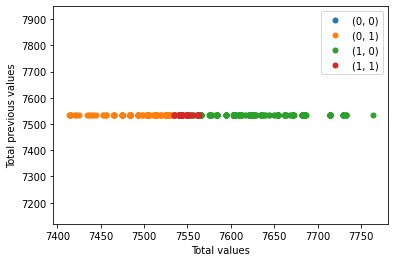

In [118]:
for name, group in groups_sim_simple:
    plt.plot(group.total_values, group.total_values_prev, marker='o', linestyle='', markersize=5, label=name)

plt.xlabel('Total values')
plt.ylabel('Total previous values')
plt.legend()

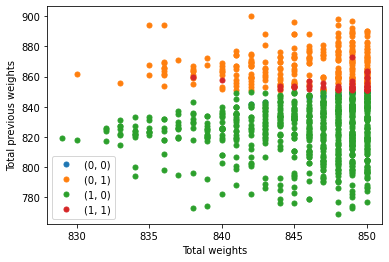

In [119]:
for name, group in groups_sim_simple:
    plt.plot(group.total_weights, group.total_weights_prev, marker='o', linestyle='', markersize=5, label=name)

plt.xlabel('Total weights')
plt.ylabel('Total previous weights')
plt.legend()

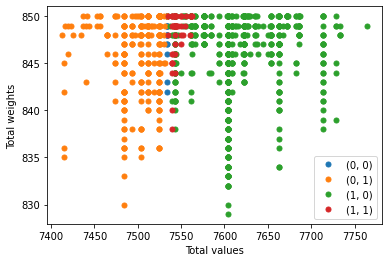

In [120]:
for name, group in groups_sim_simple:
    plt.plot(group.total_values, group.total_weights, marker='o', linestyle='', markersize=5, label=name)

plt.xlabel('Total values')
plt.ylabel('Total weights')
plt.legend()

### 2) [OPTIONAL] LET'S SEE A BIT DEEPER
##### a) Check 1st case: value <= current value and previous weight <= capacities, which is good for weight but bad for value

In [121]:
# only data points where '=' is fulfilled rather than the '<'
idx1 = df_sim_simple[(df_sim_simple['is_greater_than_capacities'] == 0) & 
                    (df_sim_simple['is_greater_than_values_prev'] == 0) &
                    (df_sim_simple['total_values'] <= df_sim_simple['total_values_prev']) &
                    (df_sim_simple['total_weights_prev'] <= capacities[0])].index[0]
df_sim_simple.iloc[idx1]

weights                        1845.00
total_values                   7534.00
total_weights                   850.00
mean_deviation_weights            2.08
total_values_prev              7534.00
total_weights_prev              850.00
is_greater_than_values_prev       0.00
is_greater_than_capacities        0.00
Name: 125, dtype: float64

##### b) Check 2nd case: value > current value and previous weight <= capacities, which is good for weight and value

In [122]:
idx2 = df_sim_simple[(df_sim_simple['is_greater_than_capacities'] == 0) & 
                    (df_sim_simple['is_greater_than_values_prev'] == 1) &
                    (df_sim_simple['total_values'] > df_sim_simple['total_values_prev']) &
                    (df_sim_simple['total_weights_prev'] <= capacities[0])].index[0]
df_sim_simple.iloc[idx2]

weights                        1823.00
total_values                   7654.00
total_weights                   846.00
mean_deviation_weights            2.16
total_values_prev              7534.00
total_weights_prev              807.00
is_greater_than_values_prev       1.00
is_greater_than_capacities        0.00
Name: 3, dtype: float64

##### c) Check 3rd case: value <= current value and previous weight > capacities, which is bad for weight and value

In [123]:
# only get where previous value is strictly lesser than current value
idx3 = df_sim_simple[(df_sim_simple['is_greater_than_capacities'] == 1) & 
                    (df_sim_simple['is_greater_than_values_prev'] == 0) &
                    (df_sim_simple['total_values'] < df_sim_simple['total_values_prev']) &
                    (df_sim_simple['total_weights_prev'] > capacities[0])].index[0]
df_sim_simple.iloc[idx3]

weights                        1900.00
total_values                   7440.00
total_weights                   849.00
mean_deviation_weights            1.46
total_values_prev              7534.00
total_weights_prev              889.00
is_greater_than_values_prev       0.00
is_greater_than_capacities        1.00
Name: 0, dtype: float64

##### d) Check 4th case: value > current value and previous weight > capacities, which is good for value but bad for weight

In [124]:
idx4 = df_sim_simple[(df_sim_simple['is_greater_than_capacities'] == 1) & 
                    (df_sim_simple['is_greater_than_values_prev'] == 1) &
                    (df_sim_simple['total_values'] > df_sim_simple['total_values_prev']) &
                    (df_sim_simple['total_weights_prev'] > capacities[0])].index[0]
df_sim_simple.iloc[idx4]

weights                        1873.00
total_values                   7543.00
total_weights                   850.00
mean_deviation_weights            1.94
total_values_prev              7534.00
total_weights_prev              856.00
is_greater_than_values_prev       1.00
is_greater_than_capacities        1.00
Name: 1, dtype: float64

### 3) ROBUST OPTIMIZATION $^{4}$
##### a) Initiate library and variables for RSOME

In [125]:
from rsome import ro
from rsome import ort_solver as ort
import rsome as rso

In [126]:
capacities_ro = capacities[0]
values_ro = np.array(values)
weights_ro = np.array(weights[0])
delta_ro = 0.2 * weights_ro

# for probability simulation later
step = 0.05
rs = np.arange(0.05, 1.0 + step, step)

##### b1) Define solver function with RSOME

In [127]:
def rsome_solver(values, weights, capacities, uncertainty_budget, is_detail=False):

    model = ro.Model('robust')
    x = model.dvar(N, vtype='B')    
    z = model.rvar(N)            
    
    z_set = (abs(z) <= 1, rso.norm(z, 1) <= (uncertainty_budget * 10))
    model.max(values @ x)
    model.st(((weights + z * delta) @ x <= capacities).forall(z_set))

    model.solve(ort, display=False)

    total_value = model.get()
    x_sol = x.get()
    total_weight = (x_sol * weights).sum()
    
    if is_detail == True:
        total_packed_weight = list((x_sol * weights).astype('int'))
        for idx in range(len(total_packed_weight)):
            if ((weights[idx] > 0) & (x_sol[idx] <= 0)):
                total_packed_weight[idx] = -1
    else:
        total_packed_weight = None
    
    return total_value, total_weight, total_packed_weight, x_sol

##### c1) Get result

In [128]:
total_value_rsome, total_weight_rsome, total_packed_weight_rsome, _ = rsome_solver(values_ro, weights_ro, capacities_ro, 0.1, True)

print('total_value:', total_value_rsome)
print('total_weight:', total_weight_rsome)
print('total_packed_weight:', total_packed_weight_rsome)

total_value: 7484.0
total_weight: 821.0
total_packed_weight: [7, 0, -1, 22, 80, -1, 11, -1, -1, -1, 59, 18, 0, -1, 3, 8, 15, 42, 9, 0, -1, 47, 52, -1, 26, -1, -1, 6, -1, 84, 2, 4, 18, -1, 7, -1, -1, -1, 71, 3, -1, 66, 31, -1, 0, -1, -1, 65, 52, 13]


##### d1) Collect simulation result from RSOME solver to a dataframe

In [129]:
# run simulation
result_sim_rsome = simulate_result(knapsack_solver, capacities, values, np.array(weights[0]), delta, zs, num_samp, total_packed_weight_rsome)

# convert dictionary to dataframe
df_sim_rsome = pd.DataFrame(result_sim_rsome)
df_sim_rsome['is_greater_than_values_prev'] = np.where(df_sim_rsome['total_values'] > df_sim_rsome['total_values_prev'], 1, 0)
df_sim_rsome['is_greater_than_capacities'] = np.where(df_sim_rsome['total_weights_prev'] > capacities_ro, 1, 0)
df_sim_rsome

,weights,total_values,total_weights,mean_deviation_weights,total_values_prev,total_weights_prev,is_greater_than_values_prev,is_greater_than_capacities
0,1900,7440,849,1.46,7484,862,0,1
1,1873,7543,850,1.94,7484,826,1,0
2,1889,7534,850,1.58,7484,823,1,0
3,1823,7654,846,2.16,7484,784,1,0
4,1820,7714,846,1.94,7484,755,1,0
...,...,...,...,...,...,...,...,...
995,1780,7663,847,2.16,7484,787,1,0
996,1822,7672,850,2.06,7484,766,1,0
997,1897,7484,841,1.20,7484,841,0,0
998,1889,7456,850,1.66,7484,854,0,1


##### d1) Visualize

In [130]:
# (0,0) --> total_values <= total_values_prev and total_weights_prev <= capacities --> weight (+) / value (+) 
# (1,0) --> total_values > total_values_prev and total_weights_prev <= capacities --> weight (+) / value (-)
# (0,1) --> total_values <= total_values_prev and total_weights_prev > capacities --> weight (-) / value (+)
# (1,1) --> total_values > total_values_prev and total_weights_prev > capacities --> weight (-) / value (-)

groups_sim_rsome = df_sim_rsome.groupby(['is_greater_than_values_prev', 'is_greater_than_capacities'])
df_summary_rsome = pd.DataFrame({'proportion': groups_sim_rsome.size() / len(df_sim_rsome)})
df_summary_rsome

proportion
is_greater_than_values_prev is_greater_than_capacities            
0                           0                                0.049
                            1                                0.036
1                           0                                0.913
                            1                                0.002

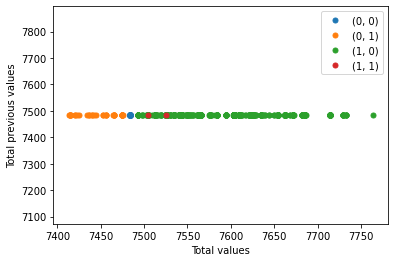

In [131]:
for name, group in groups_sim_rsome:
    plt.plot(group.total_values, group.total_values_prev, marker='o', linestyle='', markersize=5, label=name)

plt.xlabel('Total values')
plt.ylabel('Total previous values')
plt.legend()

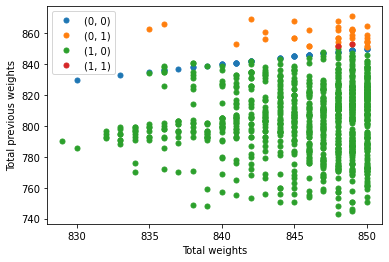

In [132]:
for name, group in groups_sim_rsome:
    plt.plot(group.total_weights, group.total_weights_prev, marker='o', linestyle='', markersize=5, label=name)

plt.xlabel('Total weights')
plt.ylabel('Total previous weights')
plt.legend()

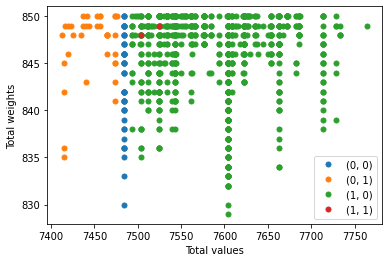

In [133]:
for name, group in groups_sim_rsome:
    plt.plot(group.total_values, group.total_weights, marker='o', linestyle='', markersize=5, label=name)

plt.xlabel('Total values')
plt.ylabel('Total weights')
plt.legend()

##### b2) Define probability simulation function

In [134]:
def sim(x_sol, zs):

    weights_sample = (weights + zs*delta).astype('int') 
    
    return (weights_sample @ x_sol > capacities).mean()

##### c2) Collect probability simulation result from RSOME solver to a dataframe

In [135]:
outputs_rb = [rsome_solver(values_ro, weights_ro, capacities_ro, r, is_detail=True) for r in rs]
total_value_prob_rsome = [output[0] for output in outputs_rb]      
total_weight_prob_rsome = [output[1] for output in outputs_rb]
total_packed_weight_prob_rsome = [output[2] for output in outputs_rb]
prob_violation_prob_rsome = [sim(np.where(np.array(output[2]) > 0, 1, 0), zs) for output in outputs_rb]

In [136]:
df_sim_prob_rsome = pd.DataFrame(list(zip(rs, total_value_prob_rsome, total_weight_prob_rsome, prob_violation_prob_rsome)), 
                     columns =['uncertainty', 'total_value', 'total_weight', 'probability_violation'])
df_sim_prob_rsome.head()

,uncertainty,total_value,total_weight,probability_violation
0,0.05,7512.0,837.0,0.154
1,0.10,7484.0,821.0,0.038
2,0.15,7484.0,821.0,0.038
3,0.20,7456.0,817.0,0.026
4,0.25,7415.0,797.0,0.001


##### d2) Visualize

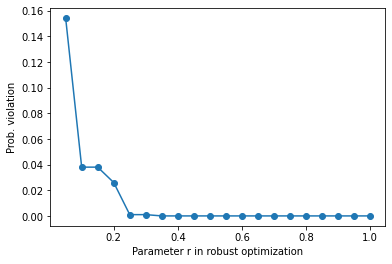

In [137]:
plt.scatter(rs, prob_violation_prob_rsome, marker='o')
plt.plot(rs, prob_violation_prob_rsome)
plt.xlabel('Parameter r in robust optimization')
plt.ylabel('Prob. violation')
plt.show()

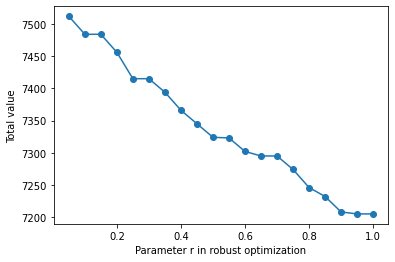

In [138]:
plt.scatter(rs, total_value_prob_rsome, marker='o')
plt.plot(rs, total_value_prob_rsome)
plt.xlabel('Parameter r in robust optimization')
plt.ylabel('Total value')
plt.show()

### 4) REFERENCES:
1. https://pubsonline.informs.org/doi/abs/10.1287/opre.1030.0065
2. http://www.optimization-online.org/DB_FILE/2021/06/8443.pdf
3. https://developers.google.com/optimization/bin/knapsack
4. https://xiongpengnus.github.io/rsome/example_ro_knapsack
5. https://en.wikipedia.org/wiki/Norm_%28mathematics%29#Properties
6. https://rorasa.wordpress.com/2012/05/13/l0-norm-l1-norm-l2-norm-l-infinity-norm/